## Group Assignment

#### Import the necessary libraries

In [387]:
import numpy as np
import pandas as pd

import datetime as dt
import yfinance as yf
import pandas_datareader.data as web

import matplotlib.pyplot as plt
%matplotlib inline

#### All questions in Parts I and II apply to a random sample of 15 stocks that your group will be assigned by running the following code.

#### Random Sample Selection 

In [388]:
np.random.seed (2051 + 6)
ticker_list = ['AAPL', 'AXP', 'BA', 'C','CAT', 'CSCO', 'CVX', 'DIS', 'GS', 'HD', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO',
            'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PFE', 'PG', 'TRV', 'UNH', 'V', 'VZ', 'WMT', 'XOM']

stock_list = np.random.choice(ticker_list,15,replace=False)
print(f'These are the fifteen stocks assigned to you: {" ".join(stock_list)}')

These are the fifteen stocks assigned to you: DIS PG V UNH CSCO PFE JPM AXP JNJ INTC KO CAT WMT CVX XOM


### PART I

#### 1. Find the optimal portfolio over the period January 2015 - December 2019, using the fifteen stocks assigned to your group. Assume there are no short-selling constraints.

In [488]:
start = dt.datetime(2015,1,1)
end = dt.datetime(2019,12,31)

stock_list=['DIS', 'PG', 'V', 'UNH', 'CSCO', 'PFE', 'JPM', 'AXP', 'JNJ', 'INTC', 'KO', 'CAT', 'WMT', 'CVX', 'XOM']

returns = yf.download(stock_list,start-pd.offsets.BDay(1),end+pd.offsets.BDay(1))['Adj Close'].pct_change().dropna()

[*********************100%***********************]  15 of 15 completed


In [489]:
from scipy.optimize import minimize

In [491]:
returns_mon = returns.resample('M').apply(lambda x: x.add(1).prod().sub(1))

In [492]:
rf = web.DataReader('F-F_Research_Data_Factors','famafrench', start, end)[0][['RF']].div(100)
rf.index = rf.index.to_timestamp(how='end').normalize()

In [493]:
def port_ret(weights):
    port_ret = np.dot(returns_mon*12,weights).mean()
    return port_ret

def port_std(weights):
    port_std = np.sqrt(np.dot(weights, np.dot(returns_mon.cov()*12, weights)))
    return port_std

def ex_port_ret(weights):
    ex_port_ret = (np.dot(returns_mon,weights) - rf['RF']).mean()*12
    return ex_port_ret

def ex_port_std(weights):
    ex_port_std = (np.dot(returns_mon,weights) - rf['RF']).std()*np.sqrt(12)
    return ex_port_std

def neg_SR(weights):
    SR = ex_port_ret(weights) / ex_port_std(weights)
    return (-1)*SR

In [494]:
constraints = ({'type':'eq','fun': lambda weights: np.sum(weights) - 1})

boundaries=[(0,1)]
bounds = tuple(boundaries * len(returns_mon.columns))

init_guess = np.full(len(returns_mon.columns), 1/len(returns_mon.columns))

In [495]:
optimal_port=minimize(neg_SR,init_guess,constraints=constraints)
optimal_port

     fun: -2.3196545169871756
     jac: array([-0.05650499, -0.05623853, -0.05728355, -0.05621591, -0.05645564,
       -0.05650467, -0.05646959, -0.05636653, -0.05608389, -0.05701184,
       -0.05645719, -0.05664587, -0.05703583, -0.05594712, -0.05632874])
 message: 'Optimization terminated successfully'
    nfev: 259
     nit: 16
    njev: 16
  status: 0
 success: True
       x: array([-0.48773918, -0.00113795,  0.02275328,  0.21573329, -0.19605763,
        0.05884937,  0.02608724,  0.51861542, -0.11671377, -0.293185  ,
        0.32401572,  0.59264372,  0.85734908,  0.04103102, -0.56224461])

#### 2. What are the weights of the stocks in the optimal portfolio?

In [496]:
for ticker in stock_list:
    result=print(ticker + "  "+ str(round(optimal_port.x[stock_list.index(ticker)],4)))

DIS  -0.4877
PG  -0.0011
V  0.0228
UNH  0.2157
CSCO  -0.1961
PFE  0.0588
JPM  0.0261
AXP  0.5186
JNJ  -0.1167
INTC  -0.2932
KO  0.324
CAT  0.5926
WMT  0.8573
CVX  0.041
XOM  -0.5622


#### 3. What was the annualized average monthly return for the optimal portfolio?

In [497]:
optimal_weights = optimal_port.x
optimal_annual_return = port_ret(optimal_weights) * 12

#### 4. What was the annualized monthly standard deviation for the optimal portfolio?

In [498]:
optimal_std=port_std(optimal_weights) * 12

#### 5. What was the Sharpe Ratio of the optimal portfolio?

In [499]:
-optimal_port.fun

2.3196545169871756

### PART II

#### 1. Create a DataFrame named optimal_weights to store the weights from a portfolio optimization performed on a rolling basis. Specifically, the optimization should use a 60 month rolling window, and be performed every month. The first 60 months correspond to the sample period for data_initial (01/2015 - 12/2019) created in question 3. Hence, the first observation in the optimal_weights DataFrame should be the weights you listed above in Part I. The next 60 month period should be 02/2015 - 01/2020, followed by 03/2015 - 02/2020, and so on. The last 60 month period should be 03/2018 - 02/2023. Again, assume there are no short-selling constraints.

In [686]:
start = dt.datetime(2015,1,1)
end = dt.datetime(2023,2,28)

stock_list=['DIS', 'PG', 'V', 'UNH', 'CSCO', 'PFE', 'JPM', 'AXP', 'JNJ', 'INTC', 'KO', 'CAT', 'WMT', 'CVX', 'XOM']

returns = yf.download(stock_list,start-pd.offsets.BDay(1),end+pd.offsets.BDay(1))['Adj Close'].pct_change().dropna()

[*********************100%***********************]  15 of 15 completed


In [687]:
rf_rate = web.DataReader('F-F_Research_Data_Factors','famafrench', start, end)[0][['RF']].div(100)
rf_rate

,RF
Date,
2015-01,0.0000
2015-02,0.0000
2015-03,0.0000
2015-04,0.0000
2015-05,0.0000
...,...
2022-10,0.0023
2022-11,0.0029
2022-12,0.0033


In [688]:
returns_mon1 = returns.resample('M').apply(lambda x: x.add(1).prod().sub(1))

In [689]:
optimal_weights = pd.DataFrame()

for i in range(0,len(returns_mon1.index)-60+1):

    def neg_SR(weights):
        SR = ((np.dot(returns_mon1.iloc[i:i+60],weights) - rf_rate.iloc[i:i+60]['RF']).mean()*(12)) /\
        ((np.dot(returns_mon1.iloc[i:i+60],weights) - rf_rate.iloc[i:i+60]['RF']).std()*np.sqrt(12))
        return (-1)*SR
    
    constraints = ({'type':'eq','fun': lambda weights: np.sum(weights) - 1})

    init_guess = np.full(len(returns_mon1.columns),1/len(returns_mon1.columns))
    
    optimal_port = minimize(neg_SR,init_guess,constraints = constraints)
    
    optimal_weights = pd.concat([optimal_weights,
                                pd.DataFrame(optimal_port.x.reshape(1,len(stock_list)).round(4),
                                             columns=[stock_list],
                                             index=[returns_mon1.iloc[i:i+60].index[-1]])],
                                axis=0)
optimal_weights.index.name='Date'
optimal_weights=optimal_weights.sort_index(axis=1)

#### 2. Create a new DataFrame named port_returns to store the monthly returns over the sample period 01/2020 - 02/2023 for the following portfolios:
 1) A monthly rebalanced portfolio using the rolling optimal weights. Specifically, the portfolio return for 01/2020 should be based on the weights as of 12/2019 (the same values detailed in Part I and in the first row in the optimal_weights DataFrame), the portfolio return for 02/2020 should be based on the weights as of 01/2020 and so on. Label the portfolio (MRoll_Reb_OP, an acronym for Monthly Rolling Rebalanced Optimal Portfolio). 
 2) A monthly rebalanced portfolio using the optimal weights as of 12/2019. Label the portfolio (M_Reb_OP, an acronym for Monthly Rebalancing Optimal Portfolio).
 3) A monthly rebalanced equally-weighted portfolio. Label the portfolio (M_Reb_EW, an acronym for Monthly Rebalancing Equally-Weighted Portfolio).
 4) A buy and hold portfolio, initially allocated according to the optimal weights as of 12/2019. Label the portfolio (BH_OP, an acronym for Buy and Hold Optimal Portfolio).
 5) A buy and hold portfolio, initially allocated equally across stocks. Label the portfolio (BH_EW, an acronym for Buy and Hold Equally-Weighted Portfolio).

In [690]:
init_guess = np.full(len(returns_mon1.columns), 1/len(returns_mon1.columns))

In [884]:
start = dt.datetime(2020,1,1)
end = dt.datetime(2023,2,28)

stock_list=['DIS', 'PG', 'V', 'UNH', 'CSCO', 'PFE', 'JPM', 'AXP', 'JNJ', 'INTC', 'KO', 'CAT', 'WMT', 'CVX', 'XOM']

prices = yf.download(stock_list,start-pd.offsets.BDay(1),end+pd.offsets.BDay(1),interval='1mo')['Adj Close']

[*********************100%***********************]  15 of 15 completed


In [875]:
inv_value = pd.DataFrame()
for column in prices:
    inv_value[column] = prices[column].div(prices[column].iloc[0])

In [876]:
#1
MRoll_Reb_OP=pd.DataFrame()
for i in range(0,len(optimal_weights)-1):
    MRoll_Reb_OP = pd.concat([MRoll_Reb_OP,
                              pd.DataFrame({'MRoll_Reb_OP':np.dot(optimal_weights.iloc[i],returns_mon1.iloc[i+60])},
                                           index = [returns_mon1.index[i+60]])],
                                           axis=0)

In [877]:
#2
M_Reb_OP = pd.DataFrame({'M_Reb_OP':np.dot(returns_mon1.iloc[0+60:], optimal_weights.iloc[0])},index = returns_mon1.index[0+60:])

In [878]:
#3
M_Reb_EW=pd.DataFrame()
for i in range(0,len(optimal_weights)-1):
    M_Reb_EW = pd.concat([M_Reb_EW,
                              pd.DataFrame({'M_Reb_EW':np.dot(init_guess,returns_mon1.iloc[i+60])},
                                           index = [returns_mon1.index[i+60]])],
                                           axis=0)

In [879]:
#4
BH_OP = pd.DataFrame({'BH_OP':np.dot(inv_value, optimal_weights.iloc[0])},index = inv_value.index).loc['2019-12-31':'2023'].pct_change().dropna()

In [880]:
#5
BH_EW = pd.DataFrame({'BH_EW':np.dot(inv_value, init_guess)},index = inv_value.index).loc['2019-12-31':'2023'].pct_change().dropna()

In [881]:
port_returns = pd.concat([MRoll_Reb_OP, M_Reb_OP, M_Reb_EW,BH_OP, BH_EW], axis=1)
port_returns

,MRoll_Reb_OP,M_Reb_OP,M_Reb_EW,BH_OP,BH_EW
2020-01-31,-0.006187,-0.006187,-0.022932,NaN,NaN
2020-02-01,NaN,NaN,NaN,0.029827,-0.106148
2020-02-29,-0.006008,0.016784,-0.106329,NaN,NaN
2020-03-01,NaN,NaN,NaN,0.037611,-0.098535
2020-03-31,0.091419,0.068890,-0.102047,NaN,NaN
...,...,...,...,...,...
2022-12-31,-0.049187,0.015731,-0.032752,NaN,NaN
2023-01-01,NaN,NaN,NaN,0.002665,0.010747
2023-01-31,0.267466,-0.052555,0.029008,NaN,NaN
2023-02-01,NaN,NaN,NaN,0.004171,-0.040889


#### 3. Create a DataFrame port_stats (with a 3x5 shape) to store the annualized average monthly return, the annualized monthly standard deviation and the Sharpe ratio for all 5 portfolios.

In [754]:
port_stats=pd.DataFrame()
port_stats['Avg Return']=port_returns.mean()*12
port_stats['Std']=port_returns.std()*np.sqrt(12)
port_stats['Sharpe']=port_returns.mean()*12/port_returns.std()*np.sqrt(12)
port_stats

,Avg Return,Std,Sharpe
MRoll_Reb_OP,0.409350,0.382746,12.834083
M_Reb_OP,0.292548,0.346766,10.123751
M_Reb_EW,0.101748,0.209412,5.830496
BH_OP,7.891321,25.828065,3.666393
BH_EW,-40.274231,54.147426,-8.925462


#### 4. Compute the cumulative return series for all portfolios and plot them in the same graph. 

<AxesSubplot: >

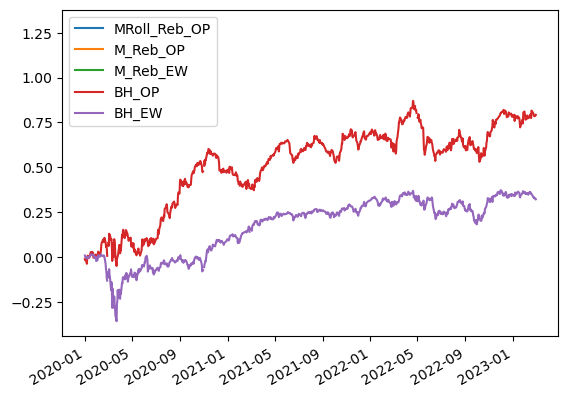

In [842]:
cum_sum=port_returns.cumsum()
cum_sum.plot()

#### 5. What was the cumulative return for the best performing portfolio? What was the cumulative return for the worst performing portfolio?

In [874]:
cum_sum=pd.DataFrame()
cum_sum['Best']=port_returns.add(1).prod().sub(1).cumsum().max()
cum_sum['Worst']=port_returns.add(1).prod().sub(1).cumsum().min()
cum_sum

,Best,Worst


### PART III - Examination of the Size Effect

Please download the file "crsp_fall22.csv" located in folder Group_Assignment. The file contains the following columns:
* PERMNO - Permanent number (unique identifer for the stock)
* DATE
* PRC - The closing price
* VOL - Trading volume (in hundreds)
* RET - The simple return
* SHROUT - The number of shares outstanding (in thousands)
* CFACPR - Cumulative factor to adjust the closing price
* CFACSHR - Cumulative factor to adjust shares outstanding

#### 1. Create a DataFrame named fin_data by reading in the columns DATE, PERMNO, RET, PRC and SHROUT from the file 'crsp_fall22.csv'. Set the DATE as the index. In addition, change each index value to the end of the month. For example, change '1926-05-30' to 1926-05-31', or '1987-01-30' to '1987-01-31'. In addition, create a new column (labeled MKTCAP) to store the market capitalization (defined as PRC * SHROUT). Subsequently, permanently remove the PRC and SHROUT columns.

In [368]:
fin_data=pd.read_csv('crsp_fall22.csv',
                     usecols=['DATE','PERMNO','RET','PRC','SHROUT'],
                     dtype={'PERMNO':np.int64},
                     index_col='DATE',
                     parse_dates=True)
fin_data.index=fin_data.index+pd.offsets.MonthEnd(0)
fin_data['MKTCAP']=fin_data['PRC']*fin_data['SHROUT']
fin_data.drop(['PRC','SHROUT'],axis=1,inplace=True)

#### 2. How many stocks are there in the sample? How many of these stocks are in the sample over the entire sample period?

In [17]:
fin_data.nunique()

PERMNO      18153
RET        828585
MKTCAP    1611452
dtype: int64

#### 3. Every June, split the stocks into quintiles (five groups) based on their market capitalization. The header of a DataFrame named size_qt with the resulting split can be found below. 

In [101]:
size_qt.sort_index().head()
#use pd.qcut

,PERMNO,MKTCAP_QT
DATE,,
1990-06-30,10294,3
1990-06-30,65496,3
1990-06-30,10905,2
1990-06-30,32037,1
1990-06-30,66288,5


#### 4. Create a new DataFrame named data by using the merge_asof() function to merge the DataFrames fin_data and size_qt. Specifically, merge each stock's June quintile allocation with the stock's monthly returns for the next 12 months starting the following July. Subsequently, set DATE as the index in the DataFrame.

In [ ]:
data=pd.DataFrame()

#### 5. Create a new DataFrame called quintiles to store the average monthly return for each quintile. The header of the DataFrame can be found below:

In [105]:
quintiles.head()

,Q1_RET,Q2_RET,Q3_RET,Q4_RET,Q5_RET
DATE,,,,,
1990-07-31,-0.001078,-0.041629,-0.044858,-0.040050,-0.028895
1990-08-31,-0.088672,-0.111944,-0.134610,-0.132793,-0.110817
1990-09-30,-0.045567,-0.090744,-0.092048,-0.099917,-0.080715
1990-10-31,-0.071408,-0.064675,-0.069424,-0.060729,-0.039041
1990-11-30,-0.011988,0.002373,0.033031,0.070116,0.099023


#### 6. Create a bar plot of the average monthly return for all five market capitalization groups, across the entire sample.

#### 7. Create a line plot of the cumulative return series for all five market capitalization groups.